In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils import (
  generate_heatmaps,
  dataframe_apply_func_axis_1
)

DATA_ROOT_PATH = "./data" # ../에서 수정
DATASET_NAME = "diabetes"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df_origin = pd.read_csv(f"{DATA_ROOT_PATH}/{DATASET_NAME}.csv")
df_origin

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# 상관관계 분석
- Dataset 을 따로 분리하지 않고 분석을 시작한다.
- 추후 Train 과 검증할 때 데이터 분리가 필요하다.

In [4]:
# 편한 문석을 위해 Outcome column 을 제일 앞에 둡니다.
# heatmap 에서 볼 때, 제일 윗줄이 Outcome 이 되도록..! 보면 됩니다.
cols = df_origin.columns.tolist()
cols = [cols.pop(), *cols]
cols

['Outcome',
 'Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [5]:
df_origin = df_origin[cols]
df_origin

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,6,148,72,35,0,33.6,0.627,50
1,0,1,85,66,29,0,26.6,0.351,31
2,1,8,183,64,0,0,23.3,0.672,32
3,0,1,89,66,23,94,28.1,0.167,21
4,1,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...,...
763,0,10,101,76,48,180,32.9,0.171,63
764,0,2,122,70,27,0,36.8,0.340,27
765,0,5,121,72,23,112,26.2,0.245,30
766,1,1,126,60,0,0,30.1,0.349,47


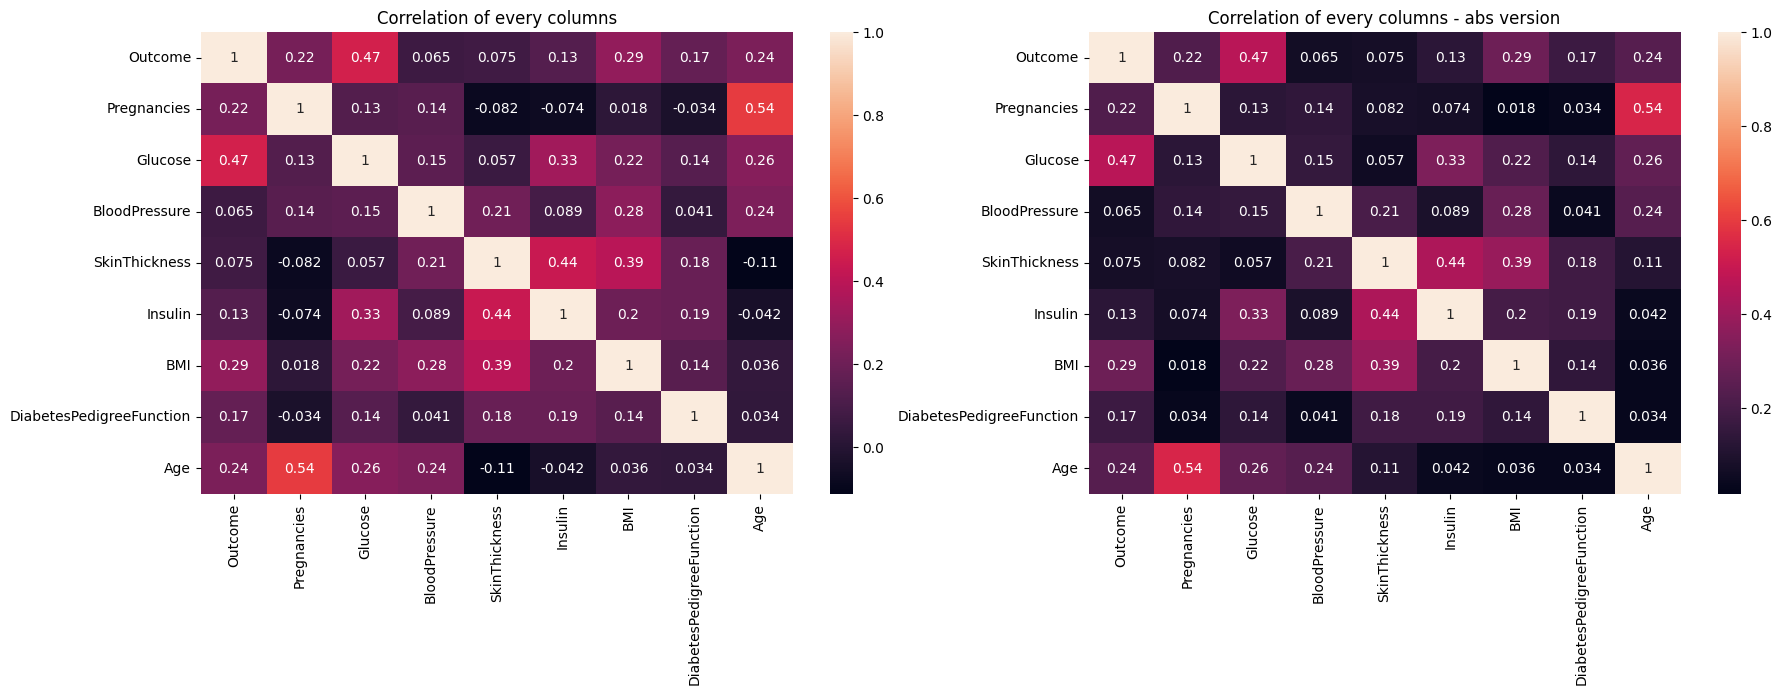

In [6]:
# 전체적인 상관관계 체크
corr = df_origin.corr()
corr_abs = corr.map(abs) # AttributeError: 'DataFrame' object has no attribute 'map'발생함

generate_heatmaps(
  [corr, corr_abs],
  ["Correlation of every columns", "Correlation of every columns - abs version"],
  21,
  annotation=True
)

## 전체적인 상관관계
### Correlation of every columns - abs version 그래프
- 포도당(Glucose) 이 Outcome column 과 가장 높은 상관관계를 보여준다.
  - 포도당과 높은 상관관계를 갖는 column 은 Outcome 다음으론 인슐린(Insulin) 이다.
  - 인슐린 다음으로는 BMI 와 Age 가 있다.
#
- BMI 가 포도당 다음으로 Outcome 과 높은 상관관계를 보여줬다.
  - BMI 와 높은 상관관계를 보여주는 항목은 피부 두께 (Skin Thickness) 이다.
#
- 다음으로 임신한 횟수 (Pregnancies) 와 나이 (Age) 가 0.2 초중반의 비슷한 상관관계를 보여준다.
  - Age 와 상관관계가 높은건 역시 Pregnancies 이다.
  - Age 는 포도당과 혈압하고 0.2 중반대의 상관관계를 보여준다.
  - Pregnancies 는 포도당과 혈압하고 0.1 초중반의 낮은 상관관계를 보여준다.
#
# 
### Correlation of every columns 그래프 참고
- 주목할만한 역관계성은 거의 것 같다.

## 포도당 (Glucose) 세부 분석
- 포도당 검사를 통해 당뇨병을 진단한다.
- 인터넷 검색 결과 당뇨 확인을 위한 포도당 수치
  - 정상 수치는 140 mg/dL 미만,
  - 200 mg/dL 미만은 당뇨병 전 단계,
  - 200 mg/dL 이상은 당뇨병
#
- 포도당을 카테고리화 하여 Outcome 과의 관계성이 높아지는지 확인한다.
- 포도당과 상관관계가 높은 컬럼들을 분석하여 관계성을 높여본다.

In [7]:
# 당뇨병은 인슐린의 분비량이 부족하거나 정상적인 기능이 이루어지지 않는 등의 대사질환의 일종으로, 혈중 포도당의 농도가 높아지는 고혈당을 특징으로 한다.
# 인슐린은 간에서 포도당의 생성을 억제하고 근육을 포함한 말초조직으로 포도당 흡수를 촉진하여 혈중 포도당 농도를 낮춥니다.

df_glucose = df_origin.copy()[['Outcome', 'Glucose', 'Insulin', 'BMI', 'Age']]
df_glucose

,Outcome,Glucose,Insulin,BMI,Age
0,1,148,0,33.6,50
1,0,85,0,26.6,31
2,1,183,0,23.3,32
3,0,89,94,28.1,21
4,1,137,168,43.1,33
...,...,...,...,...,...
763,0,101,180,32.9,63
764,0,122,0,36.8,27
765,0,121,112,26.2,30
766,1,126,0,30.1,47


In [8]:
# 포도당 수치를 카테고리화 한다.
# 140 미만, 140 이상 200 미만, 200 이상

# 140 미만은 정상수치라고 했으나 그럼에도 불구하고 당뇨병 진단을 받은 사람들이 있다.
df_glucose.loc[df_glucose.Glucose < 140, ['Outcome']].sum()

Outcome    133
dtype: int64

In [9]:
# 140 을 정상인의 기준으로 하면 안될 것 같다.
df_glucose.loc[df_glucose.Glucose >= 140, ['Outcome']].sum()

Outcome    135
dtype: int64

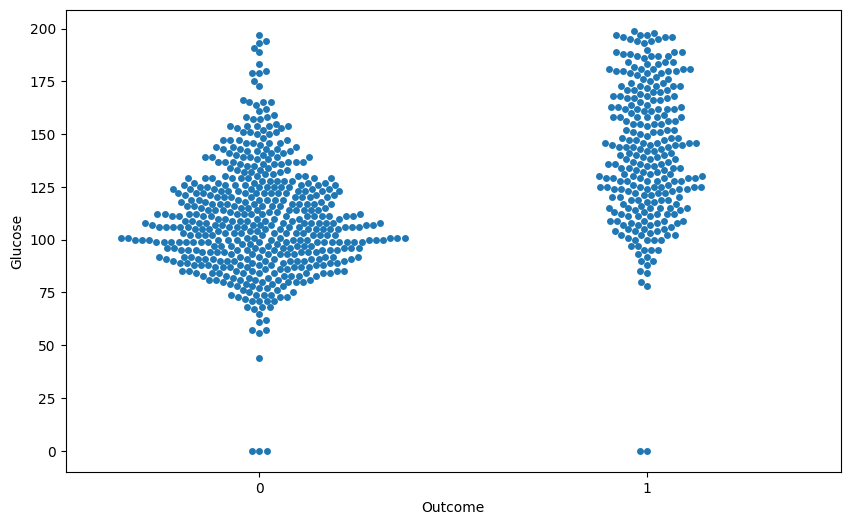

In [10]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x="Outcome", y="Glucose", data=df_glucose[['Glucose','Outcome']])
plt.show()

In [11]:
# Glucose 가 0 인 수치의 outlier 들의 데이터 확인
# 아무래도 결측치가 저렇게 들어간 것 같다.
df_glucose.sort_values('Glucose').head(10)

,Outcome,Glucose,Insulin,BMI,Age
75,0,0,0,24.7,22
502,1,0,0,39.0,41
349,1,0,0,41.0,37
342,0,0,0,32.0,22
182,0,0,23,27.7,21
62,0,44,0,25.0,36
680,0,56,45,24.2,22
537,0,57,0,21.7,67
146,0,57,0,32.8,41
352,0,61,0,34.4,46


In [12]:
# 결측치를 채우기위해 임시 데이터셋 분리
df_glucose_null = df_glucose.loc[df_glucose.Glucose == 0]
df_glucose = df_glucose.loc[df_glucose.Glucose != 0]

In [13]:
# Glucose 의 결측치를 채우기 위해 나이대별, BMI 별 Glucose 의 평균을 구해보자
df_glucose.groupby('Outcome').median

<bound method GroupBy.median of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7f19582b9840>>

In [14]:
# 포도당(Glucose)은 인슐린과 상관관계(0.33)가 높다. 
df_glucose.groupby('Outcome').mean() # outcome 별 Glucose 평균 값 

,Glucose,Insulin,BMI,Age
Outcome,,,,
0,110.643863,69.160966,30.317304,31.247485
1,142.319549,101.090226,35.106015,37.052632


In [15]:
# 결측치 채우기
df_glucose_null = df_glucose_null.apply(
  dataframe_apply_func_axis_1(
    condition={'Outcome': 1},
    do_when_true={'Glucose': 140.0},
    do_when_false={'Glucose': 107.0}
  ),
  axis=1
)
df_glucose_null

,Outcome,Glucose,Insulin,BMI,Age
75,0.0,107.0,0.0,24.7,22.0
182,0.0,107.0,23.0,27.7,21.0
342,0.0,107.0,0.0,32.0,22.0
349,1.0,140.0,0.0,41.0,37.0
502,1.0,140.0,0.0,39.0,41.0


In [16]:
# concat 두번되지 않도록 주의!!!!
df_glucose = pd.concat([df_glucose, df_glucose_null])
df_glucose.sort_index(inplace=True)
df_glucose

,Outcome,Glucose,Insulin,BMI,Age
0,1.0,148.0,0.0,33.6,50.0
1,0.0,85.0,0.0,26.6,31.0
2,1.0,183.0,0.0,23.3,32.0
3,0.0,89.0,94.0,28.1,21.0
4,1.0,137.0,168.0,43.1,33.0
...,...,...,...,...,...
763,0.0,101.0,180.0,32.9,63.0
764,0.0,122.0,0.0,36.8,27.0
765,0.0,121.0,112.0,26.2,30.0
766,1.0,126.0,0.0,30.1,47.0


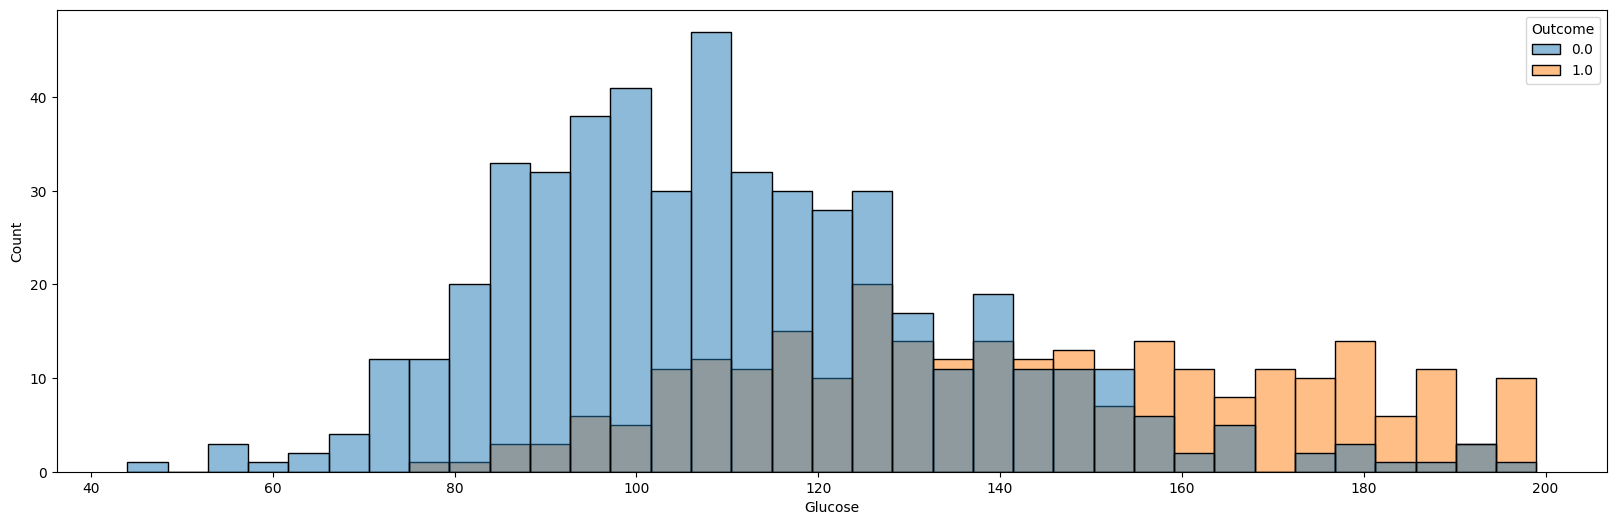

In [17]:
# Glucose 의 수치에 따라 당뇨 확진의 데이터 수를 확인합니다.
plt.figure(figsize=(20, 6))
sns.histplot(x='Glucose', hue='Outcome', data=df_glucose.sort_values('Glucose'), bins=35,)
plt.show()

In [18]:
# 위의 histogram 과 인터넷에서 확인한 당뇨병 확진 포도당 수치를 기준으로 실험한 결과입니다.
# Glucose 를 130 이하, 130 초과일 때 가장 높은 상관관계를 갖습니다.
# 130 이하 -0.42263
# 130 초과 0.42263
df_glucose = df_glucose.apply(
  dataframe_apply_func_axis_1(
    sml_or_eql={'Glucose': 130},
    do_when_true={'Glucose <= 130': 1},
    do_when_false={'Glucose <= 130': 0}
  ),
  axis=1
).apply(
  dataframe_apply_func_axis_1(
    greater_than={'Glucose': 130},
    do_when_true={'130 < Glucose': 1},
    do_when_false={'130 < Glucose': 0}
  ),
  axis=1
)

df_glucose[['Outcome', 'Glucose <= 130', '130 < Glucose']].corr()


,Outcome,Glucose <= 130,130 < Glucose
Outcome,1.00000,-0.42263,0.42263
Glucose <= 130,-0.42263,1.00000,-1.00000
130 < Glucose,0.42263,-1.00000,1.00000


In [19]:
df_glucose.corr()

,Outcome,Glucose,Insulin,BMI,Age,Glucose <= 130,130 < Glucose
Outcome,1.000000,0.495990,0.130548,0.292695,0.238356,-0.422630,0.422630
Glucose,0.495990,1.000000,0.330868,0.237464,0.268910,-0.823865,0.823865
Insulin,0.130548,0.330868,1.000000,0.197859,-0.042163,-0.265173,0.265173
BMI,0.292695,0.237464,0.197859,1.000000,0.036242,-0.211627,0.211627
Age,0.238356,0.268910,-0.042163,0.036242,1.000000,-0.271095,0.271095
Glucose <= 130,-0.422630,-0.823865,-0.265173,-0.211627,-0.271095,1.000000,-1.000000
130 < Glucose,0.422630,0.823865,0.265173,0.211627,0.271095,-1.000000,1.000000


### 포도당 수치를 통해 카테고리화 한다.
#### 카테고리화 할 수치 기준점 실험
- histogram 으로 확인한 포도당 별 당뇨 수와, 인터넷에서 확인한 당뇨병 확진 포도당 수치를 기준으로 실험했다.
- 실험 결과, 130 을 기준으로 130 이하, 130 초과 조건으로 컬럼을 나눴을 때 각 -0.422630, 0.422630 으로 수치가 가장 좋았다.
- Glucose 카테고리화 -> 130을 기준으로 두개의 컬럼으로 나누어 진행함

# 전체 컬럼들의 결측치 확인
- 위의 실험들 중 결측치가 0으로 들어가 있는것을 확인했다. 
- 모든 컬럼들에서 켤측치를 미리 확인한다.

In [20]:
col_null_cnt = dict()
for col in df_origin.columns:
    cnt = df_origin.loc[df_origin[col] == 0, [col]].count()
    col_null_cnt[col] = [cnt.values[0]]
pd.DataFrame(col_null_cnt)

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,500,111,5,35,227,374,11,0,0


In [21]:
df_glucose.groupby('Outcome').count()

,Glucose,Insulin,BMI,Age,Glucose <= 130,130 < Glucose
Outcome,,,,,,
0.0,500,500,500,500,500,500
1.0,268,268,268,268,268,268


- Skin Thickness 와 Insulin 의 결측치가 매우 많다.
- 그러나 데이터 양이 매우 적어서 저걸 삭제하면 안될 것 같다.
- 우선 저 데이터들과 Outcome 과의 연관성을 최대한 끌어내보고 대체해보자.

### 인슐린 분석
- 포도당 수치와 상관관계가 높은 인슐린 데이터를 분석하여 포도당 데이터와 결합된 새로운 컬럼을 생성한다. 

In [22]:
# 인슐린 결측치 확인 - 768 개의 데이터 중 374 개의 결측치
df_glucose.loc[df_glucose.Insulin == 0].count()

Outcome           374
Glucose           374
Insulin           374
BMI               374
Age               374
Glucose <= 130    374
130 < Glucose     374
dtype: int64

In [23]:
# 인슐린 == 0 인 경우의 데이터 확인
insulin_0 = df_glucose.loc[df_glucose.Insulin == 0]
insulin_0.groupby('Outcome').count()

,Glucose,Insulin,BMI,Age,Glucose <= 130,130 < Glucose
Outcome,,,,,,
0.0,236,236,236,236,236,236
1.0,138,138,138,138,138,138


In [24]:
# 결측치를 제거한 dataframe 에서 glucose 와의 상관관계가 0.58 로 높아졌고, 실제 Outcome 과의 상관관계 또한 0.13 에서 0.30 으로 올랐다.
# 결측치를 잘 채워주면 좋은 효과를 얻을 수 있을 것 같다.
df_glucose.loc[df_glucose.Insulin != 0].corr()

,Outcome,Glucose,Insulin,BMI,Age,Glucose <= 130,130 < Glucose
Outcome,1.000000,0.516045,0.303454,0.271796,0.352982,-0.451124,0.451124
Glucose,0.516045,1.000000,0.581513,0.206317,0.344316,-0.833317,0.833317
Insulin,0.303454,0.581513,1.000000,0.228328,0.220261,-0.484154,0.484154
BMI,0.271796,0.206317,0.228328,1.000000,0.080778,-0.163691,0.163691
Age,0.352982,0.344316,0.220261,0.080778,1.000000,-0.338102,0.338102
Glucose <= 130,-0.451124,-0.833317,-0.484154,-0.163691,-0.338102,1.000000,-1.000000
130 < Glucose,0.451124,0.833317,0.484154,0.163691,0.338102,-1.000000,1.000000


In [25]:
# 기존 데이터들로 확인 (인슐린과 포도당의 관계성 검증 및 Outcome 과 이어질 수 있는 컬럼 생성)
df_glucose_test = df_glucose.loc[df_glucose.Insulin != 0]
df_glucose_test

,Outcome,Glucose,Insulin,BMI,Age,Glucose <= 130,130 < Glucose
3,0.0,89.0,94.0,28.1,21.0,1.0,0.0
4,1.0,137.0,168.0,43.1,33.0,0.0,1.0
6,1.0,78.0,88.0,31.0,26.0,1.0,0.0
8,1.0,197.0,543.0,30.5,53.0,0.0,1.0
13,1.0,189.0,846.0,30.1,59.0,0.0,1.0
...,...,...,...,...,...,...,...
753,1.0,181.0,510.0,43.3,26.0,0.0,1.0
755,1.0,128.0,110.0,36.5,37.0,1.0,0.0
760,0.0,88.0,16.0,28.4,22.0,1.0,0.0
763,0.0,101.0,180.0,32.9,63.0,1.0,0.0


<Figure size 2000x600 with 0 Axes>

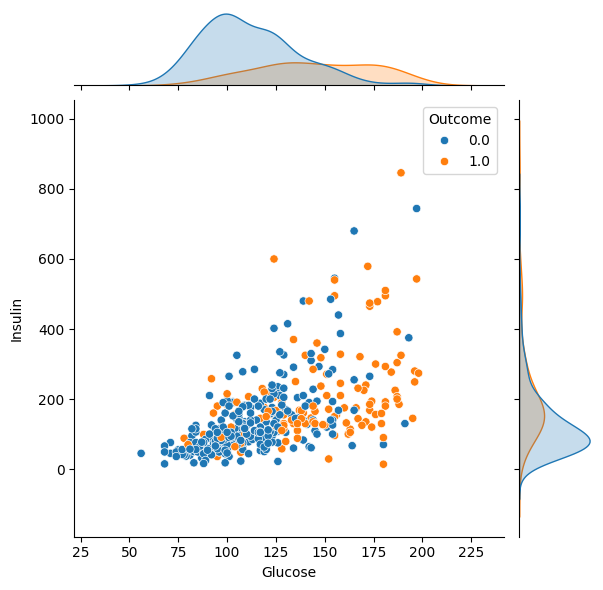

In [26]:
# 인슐린의 수치에 따라 포도당의 수치를 확인합니다.
plt.figure(figsize=(20, 6))
sns.jointplot(x=df_glucose_test['Glucose'], y=df_glucose_test['Insulin'], hue=df_glucose_test['Outcome'], kind = 'scatter')
plt.show()

- 확실히 인슐린의 양이 포도당과 연관되어있나? 

In [27]:
# test = df_glucose_test.apply(
#   dataframe_apply_func_axis_1(
#     greater_than={'diff_glc_insln': 80},
#     do_when_true={'diff_glc_insln_huge': 1},
#     do_when_false={'diff_glc_insln_huge': 0},
#   ),
#   axis=1
# )
df_glucose_test['diff_multi'] = (df_glucose_test.Glucose - df_glucose_test.Insulin) * df_glucose_test.Insulin.mean()
df_glucose_test.corr()

/tmp/ipykernel_4075/3067699487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glucose_test['diff_multi'] = (df_glucose_test.Glucose - df_glucose_test.Insulin) * df_glucose_test.Insulin.mean()


,Outcome,Glucose,Insulin,BMI,Age,Glucose <= 130,130 < Glucose,diff_multi
Outcome,1.000000,0.516045,0.303454,0.271796,0.352982,-0.451124,0.451124,-0.193897
Glucose,0.516045,1.000000,0.581513,0.206317,0.344316,-0.833317,0.833317,-0.368280
Insulin,0.303454,0.581513,1.000000,0.228328,0.220261,-0.484154,0.484154,-0.970517
BMI,0.271796,0.206317,0.228328,1.000000,0.080778,-0.163691,0.163691,-0.199808
Age,0.352982,0.344316,0.220261,0.080778,1.000000,-0.338102,0.338102,-0.149703
Glucose <= 130,-0.451124,-0.833317,-0.484154,-0.163691,-0.338102,1.000000,-1.000000,0.306401
130 < Glucose,0.451124,0.833317,0.484154,0.163691,0.338102,-1.000000,1.000000,-0.306401
diff_multi,-0.193897,-0.368280,-0.970517,-0.199808,-0.149703,0.306401,-0.306401,1.000000


<Figure size 2000x600 with 0 Axes>

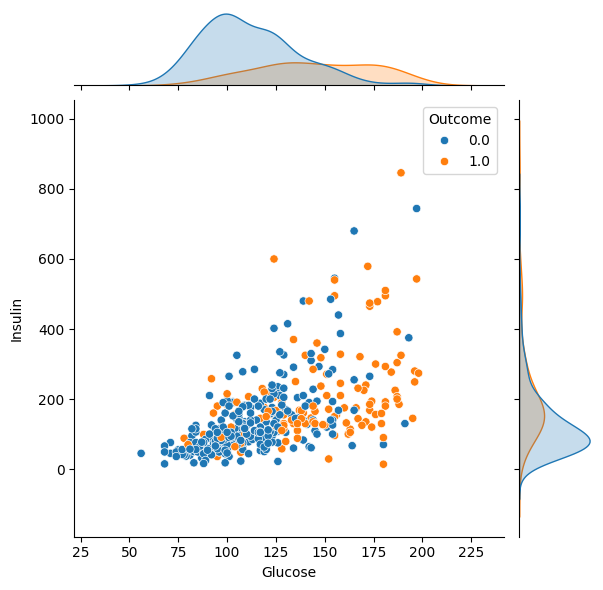

In [28]:
plt.figure(figsize=(20, 6))
sns.jointplot(x=df_glucose_test['Glucose'], y=df_glucose_test['Insulin'], hue=df_glucose_test['Outcome'], kind = 'scatter')
plt.show()

# 모델 코드
- original dataset 을 활용한 모델과 accuracy

Accuracy: 0.7792207792207793


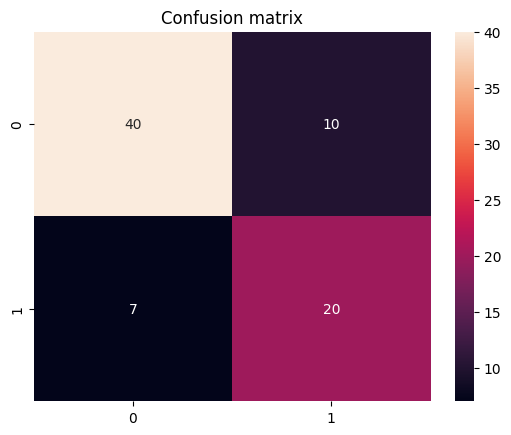

              precision    recall  f1-score   support

           0       0.85      0.80      0.82        50
           1       0.67      0.74      0.70        27

    accuracy                           0.78        77
   macro avg       0.76      0.77      0.76        77
weighted avg       0.79      0.78      0.78        77



In [29]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, GridSearchCV

X = df_origin.drop(['Outcome'], axis=1)
y = df_origin['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = DecisionTreeClassifier(random_state=202311)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')

sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion matrix')
plt.show()

print(class_report)

- KNN 사용해보기

In [31]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [32]:
print(train_scores)
print(test_scores)

[1.0, 0.8364688856729378, 0.8567293777134588, 0.8205499276410999, 0.7973950795947902, 0.7872648335745297, 0.7872648335745297, 0.7829232995658466, 0.7858176555716353, 0.7858176555716353, 0.7858176555716353, 0.7858176555716353, 0.7872648335745297, 0.7814761215629522]
[0.6233766233766234, 0.7402597402597403, 0.6623376623376623, 0.7012987012987013, 0.6493506493506493, 0.7142857142857143, 0.6753246753246753, 0.7142857142857143, 0.6493506493506493, 0.6493506493506493, 0.6753246753246753, 0.7402597402597403, 0.7272727272727273, 0.7532467532467533]


In [33]:
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [34]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.7578558696205755
Best Parameters: {'n_neighbors': 14}


- XGBoost 사용해보기

In [35]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

params = {
    "max_depth": 3, 
    "eta": 0.0015, 
    "objective": "binary:logistic", 
    "eval_metric": "logloss"
}

# X_train의 열 이름을 가져와서 feature_names 설정
feature_names = X_train.columns.tolist()

dtrain = xgb.DMatrix(X_train, label=y_train,feature_names =feature_names)
dtest = xgb.DMatrix(X_test, label=y_test,feature_names =feature_names)

num_round = 1700  # 부스팅 라운드 수 (트리의 개수)
wlist = [(dtrain, "train"), (dtest, "eval")]
model = xgb.train(params, dtrain, num_round,evals = wlist)

# 테스트 데이터에 대한 예측을 수행합니다
predictions = model.predict(dtest)

[0]	train-logloss:0.64623	eval-logloss:0.64742
[1]	train-logloss:0.64573	eval-logloss:0.64699
[2]	train-logloss:0.64524	eval-logloss:0.64655
[3]	train-logloss:0.64474	eval-logloss:0.64612
[4]	train-logloss:0.64425	eval-logloss:0.64569
[5]	train-logloss:0.64376	eval-logloss:0.64526
[6]	train-logloss:0.64327	eval-logloss:0.64483
[7]	train-logloss:0.64279	eval-logloss:0.64440
[8]	train-logloss:0.64230	eval-logloss:0.64397
[9]	train-logloss:0.64182	eval-logloss:0.64355
[10]	train-logloss:0.64133	eval-logloss:0.64313
[11]	train-logloss:0.64085	eval-logloss:0.64270
[12]	train-logloss:0.64037	eval-logloss:0.64228
[13]	train-logloss:0.63990	eval-logloss:0.64184
[14]	train-logloss:0.63942	eval-logloss:0.64143
[15]	train-logloss:0.63894	eval-logloss:0.64099
[16]	train-logloss:0.63847	eval-logloss:0.64056
[17]	train-logloss:0.63800	eval-logloss:0.64015
[18]	train-logloss:0.63752	eval-logloss:0.63971
[19]	train-logloss:0.63705	eval-logloss:0.63931
[20]	train-logloss:0.63659	eval-logloss:0.63888
[2

In [36]:
pred = [1 if x > 0.5 else 0 for x in predictions]


In [37]:
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}")

정확도: 0.7403, 정밀도: 0.6400, 재현율: 0.5926, F1: 0.6154


- cross-validate를 이용해 randomforest 파라미터 바꾸어 보기

In [38]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
clf = RandomForestClassifier(n_estimators=300, max_depth=8, random_state=2023)
scores = cross_validate(clf, X, y, scoring=scoring, cv=5)

scores_df = pd.DataFrame(scores)
pd.concat([scores_df, scores_df.apply(['mean', 'std'])]) # NaN

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.872618,0.048893,0.759740,0.680851,0.592593,0.633663
1,0.763927,0.039603,0.707792,0.581818,0.592593,0.587156
2,0.628388,0.039608,0.766234,0.750000,0.500000,0.600000
3,0.609058,0.039073,0.836601,0.818182,0.679245,0.742268
4,0.618539,0.038207,0.764706,0.717949,0.528302,0.608696
mean,0.698506,0.041077,0.767015,0.709760,0.578546,0.634357
std,0.116090,0.004406,0.045849,0.087531,0.069334,0.062674


In [39]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
clf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=2023)
scores = cross_validate(clf, X, y, scoring=scoring, cv=5)

scores_df = pd.DataFrame(scores)
pd.concat([scores_df, scores_df.apply(['mean', 'std'])]) # NaN

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.657892,0.038921,0.759740,0.673469,0.611111,0.640777
1,0.635624,0.039373,0.707792,0.584906,0.574074,0.579439
2,0.627153,0.038879,0.772727,0.806452,0.462963,0.588235
3,0.669381,0.044209,0.849673,0.826087,0.716981,0.767677
4,1.474459,0.130566,0.771242,0.725000,0.547170,0.623656
mean,0.812902,0.058390,0.772235,0.723183,0.582460,0.639957
std,0.370207,0.040410,0.050761,0.098892,0.092887,0.075691


In [40]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
clf = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=2023)
scores = cross_validate(clf, X, y, scoring=scoring, cv=5)

scores_df = pd.DataFrame(scores)
pd.concat([scores_df, scores_df.apply(['mean', 'std'])]) # NaN

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,2.355828,0.135922,0.759740,0.673469,0.611111,0.640777
1,2.101287,0.057622,0.707792,0.584906,0.574074,0.579439
2,1.089301,0.057591,0.785714,0.800000,0.518519,0.629213
3,1.039135,0.058869,0.849673,0.826087,0.716981,0.767677
4,1.042741,0.062000,0.777778,0.743590,0.547170,0.630435
mean,1.525658,0.074401,0.776140,0.725610,0.593571,0.649508
std,0.648238,0.034438,0.051093,0.098068,0.076980,0.070224


Accuracy: 0.6753246753246753


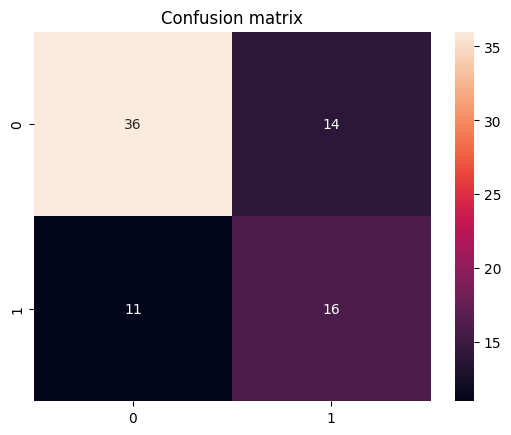

              precision    recall  f1-score   support

           0       0.77      0.72      0.74        50
           1       0.53      0.59      0.56        27

    accuracy                           0.68        77
   macro avg       0.65      0.66      0.65        77
weighted avg       0.68      0.68      0.68        77



In [41]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=202311)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')

sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion matrix')
plt.show()

print(class_report)

- OverSampling 진행 SMOTE사용

In [76]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# df_glucose에는 원래 데이터프레임이 들어가야 합니다.
# Outcome=0인 데이터가 500개, Outcome=1인 데이터가 268개인 경우
df_glucose_resampled = df_glucose.copy()

# Outcome=1인 데이터 수를 500개로 늘리기 위해 SMOTE를 적용
smote = SMOTE(sampling_strategy=0.9, random_state=2023)
X_resampled, y_resampled = smote.fit_resample(df_glucose_resampled.drop('Outcome', axis=1), df_glucose_resampled['Outcome'])

# 새로운 데이터프레임 생성
df_resampled = pd.DataFrame(X_resampled, columns=df_glucose_resampled.columns[:-1])
df_resampled['Outcome'] = y_resampled

# Outcome=1인 데이터 수 확인
print(df_resampled['Outcome'].value_counts())

Outcome
0.0    500
1.0    450
Name: count, dtype: int64


In [77]:
df_resampled.groupby('Outcome').count()

,Glucose,Insulin,BMI,Age,Glucose <= 130
Outcome,,,,,
0.0,500,500,500,500,500
1.0,450,450,450,450,450


Accuracy: 0.7578947368421053


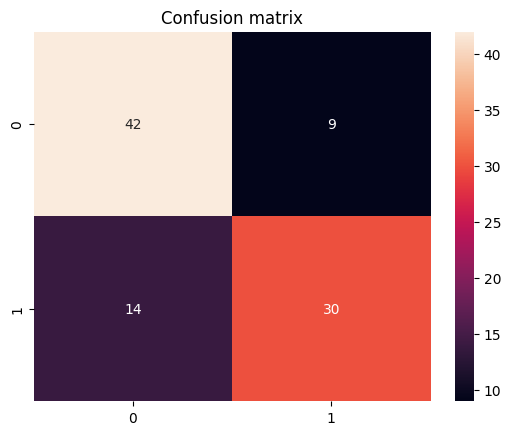

              precision    recall  f1-score   support

         0.0       0.75      0.82      0.79        51
         1.0       0.77      0.68      0.72        44

    accuracy                           0.76        95
   macro avg       0.76      0.75      0.75        95
weighted avg       0.76      0.76      0.76        95



In [78]:
X = df_resampled.drop(['Outcome'], axis=1)
y = df_resampled['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = DecisionTreeClassifier(random_state=202311)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')

sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion matrix')
plt.show()

print(class_report)

In [79]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
clf = RandomForestClassifier(n_estimators=300, max_depth=8, random_state=2023)
scores = cross_validate(clf, X, y, scoring=scoring, cv=5)

scores_df = pd.DataFrame(scores)
pd.concat([scores_df, scores_df.apply(['mean', 'std'])]) # NaN

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.846649,0.056746,0.763158,0.731959,0.788889,0.759358
1,0.897377,0.061859,0.710526,0.696629,0.688889,0.692737
2,0.857184,0.059751,0.763158,0.771084,0.711111,0.739884
3,0.881850,0.061222,0.852632,0.822917,0.877778,0.849462
4,21.503174,0.073045,0.815789,0.761905,0.888889,0.820513
mean,4.997247,0.062525,0.781053,0.756899,0.791111,0.772391
std,9.227116,0.006203,0.054646,0.047008,0.092095,0.062903


In [80]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
clf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=2023)
scores = cross_validate(clf, X, y, scoring=scoring, cv=5)

scores_df = pd.DataFrame(scores)
pd.concat([scores_df, scores_df.apply(['mean', 'std'])]) # NaN

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,0.876913,0.041733,0.763158,0.741935,0.766667,0.754098
1,0.662371,0.040807,0.715789,0.719512,0.655556,0.686047
2,0.678741,0.041096,0.752632,0.759036,0.700000,0.728324
3,0.668894,0.041779,0.873684,0.823529,0.933333,0.875000
4,0.669195,0.041480,0.789474,0.735849,0.866667,0.795918
mean,0.711223,0.041379,0.778947,0.755972,0.784444,0.767877
std,0.092807,0.000419,0.059196,0.040326,0.115095,0.071959


In [81]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
clf = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=2023)
scores = cross_validate(clf, X, y, scoring=scoring, cv=5)

scores_df = pd.DataFrame(scores)
pd.concat([scores_df, scores_df.apply(['mean', 'std'])]) # NaN

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,1.220596,0.063140,0.763158,0.741935,0.766667,0.754098
1,1.103472,0.063236,0.715789,0.714286,0.666667,0.689655
2,1.135603,0.061840,0.752632,0.752941,0.711111,0.731429
3,1.149888,0.062509,0.873684,0.817308,0.944444,0.876289
4,1.110046,0.061952,0.789474,0.735849,0.866667,0.795918
mean,1.143921,0.062536,0.778947,0.752464,0.791111,0.769478
std,0.046817,0.000649,0.059196,0.038889,0.113692,0.070999
